# Exploratory Data Analysis (EDA) — NYC Yellow Taxi 2024

## Introduction

In this section, we will perform an exploratory data analysis (EDA) on the full 12-month NYC Yellow Taxi Trip dataset, now fully loaded into MySQL (~41M records). The goal is to extract key insights and trends from the data, including:

- Total trips per month
- Average fare and tip analysis
- Payment type trends

## Why we are creating indexes

Since the dataset is large (~41 million rows), performing aggregation queries directly on the raw table can be very slow. To optimize query performance for our EDA, we will create indexes on the columns that are most frequently used in `GROUP BY`, `WHERE`, and `ORDER BY` clauses:

- `pu_location_id` → used for geospatial and pickup analysis
- `do_location_id` → used for dropoff analysis
- `tpep_pickup_datetime` → used to group trips by month and time

Creating these indexes will significantly improve the speed of our queries and make the analysis more efficient and interactive.

**Note:** The index creation step is safe to run multiple times — if an index already exists, MySQL will report it and skip re-creating it.


In [2]:
import mysql.connector
from dotenv import load_dotenv
import os

# Load env variables
load_dotenv()

# MySQL connection config
MYSQL_CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('MYSQL_HOST'),
    'database': os.getenv('MYSQL_DATABASE'),
    'port': int(os.getenv('MYSQL_PORT'))
}

## Index Management

To optimize query performance on the `yellow_taxi_trips` table (~41M rows), we use dedicated indexes on key columns:

- `pu_location_id` → for pickup zone analysis
- `do_location_id` → for dropoff zone analysis
- `tpep_pickup_datetime` → for time-based aggregations (e.g. trips per month)

### Why use flags to control index operations?

- Creating or dropping indexes on large tables can take several minutes.
- Even attempting to create an index that already exists forces MySQL to check the table and can cause temporary performance impact.
- For this reason, index operations are controlled explicitly by `DROP_INDEXES` and `CREATE_INDEXES` flags in the notebook.

**Usage:**

- Set `DROP_INDEXES = True` to drop existing indexes if needed.
- Set `CREATE_INDEXES = True` to create the required indexes (usually run once during setup).
- Default is to skip both operations to ensure fast and safe re-runs of the notebook.

### Notes:

- Dropping and recreating indexes is safe: it does not affect the underlying table data.
- It is good practice to document and control index management in reproducible analytical pipelines.


In [ ]:
# Index Management Block
# ⚙️ Use DROP_INDEXES and CREATE_INDEXES flags to control index operations.
# ⚠️ On large tables (~41M rows), index operations can take several minutes.

DROP_INDEXES = False  # Set to True to drop existing indexes (if needed)
CREATE_INDEXES = False  # Set to True to create indexes (recommended to run only once)

# Indexes to manage
index_names = [
    "idx_pu_location_id",
    "idx_do_location_id",
    "idx_tpep_pickup_datetime"
]

index_statements = [
    ("idx_pu_location_id", "CREATE INDEX idx_pu_location_id ON yellow_taxi_trips(pu_location_id);"),
    ("idx_do_location_id", "CREATE INDEX idx_do_location_id ON yellow_taxi_trips(do_location_id);"),
    ("idx_tpep_pickup_datetime", "CREATE INDEX idx_tpep_pickup_datetime ON yellow_taxi_trips(tpep_pickup_datetime);")
]

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# Drop indexes if requested
if DROP_INDEXES:
    print("⚠️ Dropping indexes...")
    for index_name in index_names:
        try:
            print(f"Dropping index {index_name}...")
            cursor.execute(f"DROP INDEX {index_name} ON yellow_taxi_trips;")
            cnx.commit()
            print(f"✅ Index {index_name} dropped.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not drop index {index_name}: {err.msg}")
    print("🏁 Index drop process complete.")
else:
    print("⏭️ Skipping index drop.")

# Create indexes if requested
if CREATE_INDEXES:
    print("⚙️ Creating indexes...")
    for index_name, stmt in index_statements:
        try:
            print(f"Creating index {index_name}...")
            cursor.execute(stmt)
            cnx.commit()
            print(f"✅ Index {index_name} created.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not create index {index_name}: {err.msg}")
    print("🏁 Index creation process complete.")
else:
    print("⏭️ Skipping index creation.")

# Close connection
cursor.close()
cnx.close()


⏭️ Skipping index drop.
⏭️ Skipping index creation.


`On the initial run:`
```text
⚠️ Dropping indexes...
Dropping index idx_pu_location_id...
✅ Index idx_pu_location_id dropped.
Dropping index idx_do_location_id...
✅ Index idx_do_location_id dropped.
Dropping index idx_tpep_pickup_datetime...
⚠️ Could not drop index idx_tpep_pickup_datetime: Can't DROP 'idx_tpep_pickup_datetime'; check that column/key exists
🏁 Index drop process complete.
⚙️ Creating indexes...
Creating index idx_pu_location_id...
✅ Index idx_pu_location_id created.
Creating index idx_do_location_id...
✅ Index idx_do_location_id created.
Creating index idx_tpep_pickup_datetime...
✅ Index idx_tpep_pickup_datetime created.
🏁 Index creation process complete.
```

## Total Trips per Month

We analyze the evolution of total trips over time (monthly) to detect seasonality and trends in NYC taxi usage.


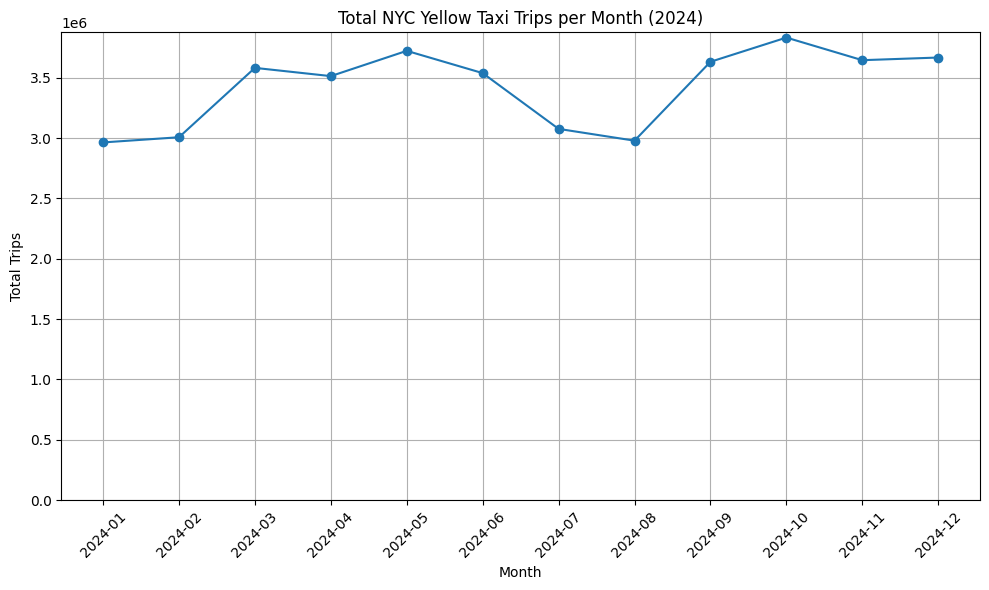

In [7]:
# Total Trips per Month

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# SQL query: total trips per month
query = """
SELECT
    DATE_FORMAT(tpep_pickup_datetime, '%Y-%m') AS month,
    COUNT(*) AS total_trips
FROM yellow_taxi_trips
GROUP BY month
ORDER BY month;
"""

# Execute query
cursor.execute(query)
results = cursor.fetchall()

# Close connection
cursor.close()
cnx.close()

# Load results into DataFrame
df_trips_per_month = pd.DataFrame(results, columns=['month', 'total_trips'])

# Filter only valid 2024 dates (strict sanity check)
df_trips_valid = df_trips_per_month[df_trips_per_month['month'].between('2024-01', '2024-12')]

# Plot only valid months
plt.figure(figsize=(10,6))
plt.plot(df_trips_valid['month'], df_trips_valid['total_trips'], marker='o')
plt.title('Total NYC Yellow Taxi Trips per Month (2024)')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save clean version to CSV
df_trips_valid.to_csv('../eda_results/total_trips_per_month_2024_clean.csv', index=False)


## Data Quality Assessment

During the initial exploratory analysis, we observed some data quality issues — specifically, trips with pickup dates outside of the expected 2024 range.

This is a common situation when working with large real-world datasets, such as the NYC Yellow Taxi Trip Data. Data inconsistencies may arise from:

- Incorrect timestamps (e.g. due to device clock errors)
- Missing or null values
- Unexpected values in categorical columns (e.g. invalid payment type codes)
- Outliers in numerical fields (e.g. negative trip distances or fares)

Before proceeding with further analysis, we will perform a basic data quality assessment to better understand the overall condition of our dataset. This step ensures that we can make informed decisions about cleaning and filtering the data for reliable insights.


In [9]:
# Data Quality Checks

import pandas as pd
import mysql.connector
import os

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# 1️⃣ Pickup datetime: min and max
query_dates = """
SELECT
    MIN(tpep_pickup_datetime) AS min_pickup_datetime,
    MAX(tpep_pickup_datetime) AS max_pickup_datetime
FROM yellow_taxi_trips;
"""
cursor.execute(query_dates)
dates_result = cursor.fetchall()
df_dates = pd.DataFrame(dates_result, columns=['min_pickup_datetime', 'max_pickup_datetime'])
df_dates.to_csv('../eda_results/data_quality_pickup_datetime_range.csv', index=False)

# 2️⃣ Null value counts
query_nulls = """
SELECT
    SUM(tpep_pickup_datetime IS NULL) AS pickup_nulls,
    SUM(tpep_dropoff_datetime IS NULL) AS dropoff_nulls,
    SUM(passenger_count IS NULL) AS passenger_count_nulls,
    SUM(trip_distance IS NULL) AS trip_distance_nulls,
    SUM(fare_amount IS NULL) AS fare_amount_nulls,
    SUM(payment_type IS NULL) AS payment_type_nulls
FROM yellow_taxi_trips;
"""
cursor.execute(query_nulls)
nulls_result = cursor.fetchall()
df_nulls = pd.DataFrame(nulls_result, columns=[
    'pickup_nulls', 'dropoff_nulls', 'passenger_count_nulls',
    'trip_distance_nulls', 'fare_amount_nulls', 'payment_type_nulls'
])
df_nulls.to_csv('../eda_results/data_quality_null_counts.csv', index=False)

# 3️⃣ Negative trip distance and fare amounts
query_negatives = """
SELECT
    SUM(trip_distance < 0) AS negative_trip_distance,
    SUM(fare_amount < 0) AS negative_fare_amount
FROM yellow_taxi_trips;
"""
cursor.execute(query_negatives)
negatives_result = cursor.fetchall()
df_negatives = pd.DataFrame(negatives_result, columns=['negative_trip_distance', 'negative_fare_amount'])
df_negatives.to_csv('../eda_results/data_quality_negative_values.csv', index=False)

# 4️⃣ Unexpected payment_type values
# Valid values: 1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown, 6=Voided trip
query_payment_types = """
SELECT
    payment_type,
    COUNT(*) AS count
FROM yellow_taxi_trips
GROUP BY payment_type
ORDER BY payment_type;
"""
cursor.execute(query_payment_types)
payment_types_result = cursor.fetchall()
df_payment_types = pd.DataFrame(payment_types_result, columns=['payment_type', 'count'])
df_payment_types.to_csv('../eda_results/data_quality_payment_type_distribution.csv', index=False)

# Close connection
cursor.close()
cnx.close()

# Summary printout
print("✅ Data Quality Checks completed.")
print("✅ Results saved to '../eda_results/' folder:")
print("- data_quality_pickup_datetime_range.csv")
print("- data_quality_null_counts.csv")
print("- data_quality_negative_values.csv")
print("- data_quality_payment_type_distribution.csv")


✅ Data Quality Checks completed.
✅ Results saved to '../eda_results/' folder:
- data_quality_pickup_datetime_range.csv
- data_quality_null_counts.csv
- data_quality_negative_values.csv
- data_quality_payment_type_distribution.csv
